# Evaluate a pretrained detector on custom coco style dataset

In [1]:
from PIL import Image
import torch
import json
import numpy as np
import cv2
import torchvision.transforms.functional as F
#from albumentations.pytorch.transforms import ToTensorV2
import os
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

C:\Users\marce\anaconda3\envs\msc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Prepare dataset

Implement map-style dataset __getitem__() (as opposed to iterable-style __iter__())

In [2]:
class CocoDetection(torch.utils.data.Dataset):
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """

    def __init__(self, root, annFile, transform=None, target_transform=None):
        self.root = root
        self.coco = COCO(annFile)
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']

        img = Image.open(self.root + path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


    def __len__(self):
        return len(self.ids)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

Visualizing and verifying dataset

In [3]:
img_dir = os.path.abspath("coco_train_m_1_False_gamedrill")
annotation = img_dir + "/annot.json"
dataset = CocoDetection(
    root=img_dir,
    annFile=annotation ,
    #transforms=ToTensorV2(),
)
img, target = dataset[5]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
target

[{'area': 1600,
  'iscrowd': 0,
  'bbox': [152, 210, 40, 40],
  'category_id': 1,
  'ignore': 0,
  'segmentation': [],
  'image_id': 6,
  'id': 6}]

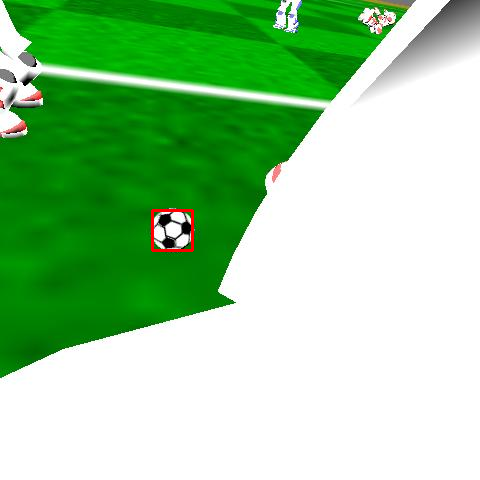

In [5]:
x1 = target[0]["bbox"][0]
y1 = target[0]["bbox"][1]
x2 = x1+target[0]["bbox"][2]
y2 = y1+target[0]["bbox"][3]

display_img = cv2.rectangle(np.array(img), (x1, y1), (x2, y2), (255, 0, 0), 2)
F.to_pil_image(display_img)

### Prepare detector

Load pretrained model

In [6]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in C:\Users\marce/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-13 Python-3.9.16 torch-1.13.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


Perform inference for one test image

In [7]:
result = model(img)

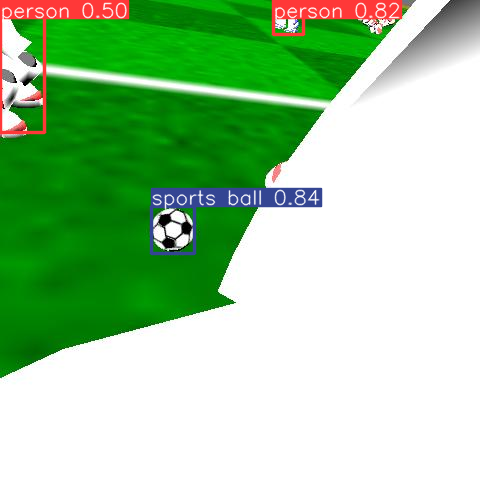

In [8]:
result.show()

In [9]:
result.pandas().xyxy[0] 

,xmin,ymin,xmax,ymax,confidence,class,name
0,151.215134,206.837997,194.010406,253.607391,0.841057,32,sports ball
1,273.859222,0.000000,303.220551,34.502682,0.818996,0,person
2,0.259179,0.589016,44.718750,132.518677,0.497659,0,person


### Evaluate mAP

Perform inference on dataset and convert to coco style results

In [10]:
call_list = np.arange(1,50).tolist()
im_id_list = []
preds = []

for call_no in call_list:
    print(call_no)

    img, target = dataset[call_no]
    im_id_list.append(target[0]['image_id'])
    
    result = model(img)
    detections = result.xyxy[0]  # Batch size of 1
    if len(detections)>0:
        for detect in detections:  # [x_min, y_min, x_max, y_max, score, class]
            scores = detect[4].tolist()
            
            boxes = detect[0:4].type(torch.int64).tolist()
            # from xyxy to xywh
            boxes[2] = boxes[2]-boxes[0]
            boxes[3] = boxes[3]-boxes[1]
            
            labels = detect[5].type(torch.int64).tolist()
            
            # Consider only ball detections
            if labels == 32:
                labels = 1  # Convert standard coco to custom coco
            else:
                continue
            
            preds.append(
                dict(
                    image_id = target[0]['image_id'],
                    category_id=labels,
                    bbox=boxes,
                    score=round(scores,3),
                )
            )

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Save results

In [11]:
resFile = "./detection_cocoresults.json"
with open(resFile, 'w') as out_file:
    json.dump(preds, out_file)

Load ground truth annotations and predictions

In [12]:
cocoGt = COCO(annotation)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [13]:
cocoDt = cocoGt.loadRes(resFile)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


Prepare evaluation function

In [14]:
cocoEval = COCOeval(cocoGt=cocoGt, cocoDt=cocoDt, iouType='bbox')
cocoEval.params.imgIds  = im_id_list
cocoEval.params.useCats = True
cocoEval.params.catIds = 1

Compute mAP scores

In [15]:
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.400
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.724
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.373
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.403
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.453
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=